In [2]:
import os
import wfdb
from wfdb import processing
import numpy as np
from scipy import interpolate

In [132]:
class HeartbeatSlicer:
    def __init__(self, record_path, sampfrom, sampto):
        self.record = wfdb.rdrecord(record_name=record_path, sampfrom=sampfrom, sampto=sampto)
        self.annotations = wfdb.rdann(record_name=record_path, extension='atr', sampfrom=sampfrom, sampto=sampto, shift_samps=True)
        self.ecg_data = self.record.p_signal[:, 0]
        self.sampling_rate = self.record.fs
        self.peak_indices = self.detect_peaks()


    def detect_peaks(self):
        """
        Detects peaks in the ECG data.

        Returns: numpy array with the indices of peaks.
        """

        #qrs_detector = wfdb.processing.XQRS(sig=self.ecg_data, fs=self.sampling_rate)
        #qrs_detector.detect()
        #peak_indices = qrs_detector.qrs_inds

        peak_indices = processing.gqrs_detect(sig=self.ecg_data, fs=self.sampling_rate)

        return peak_indices


    def interpolate_sequence(self):
        x = np.linspace(0, len(self.peak_indices) - 1, len(self.peak_indices) - 1)
        f = interpolate.interp1d(np.arange(len(self.peak_indices)), self.peak_indices, kind='cubic')
        print(f(x))

        return f(x)

    def slice_heartbeats(self, num_heartbeats):
        """
        Slice the ECG data into sequences of a fixed number of consecutive heartbeats.

        num_heartbeats : The number of consecutive heartbeats to include in each sequence.

        Returns: 2D numpy array, each row is a sequence of heartbeats.
        """
        sequences = []

        # FIXME: slicing steps
        for i in range(2, len(self.peak_indices)-num_heartbeats):
            start = self.peak_indices[i] - (self.peak_indices[i] - self.peak_indices[i-num_heartbeats])//2
            end = self.peak_indices[i] +  (self.peak_indices[i+num_heartbeats] - self.peak_indices[i])//2
            sequence = self.ecg_data[start:end]

            sequences.append(sequence)



        return sequences



In [133]:
record = wfdb.rdrecord(record_name='data_original/nsrdb/1.0.0/16265', sampfrom=2000, sampto=5000)
annotation = wfdb.rdann('data_original/nsrdb/1.0.0/16265', 'atr', sampfrom=2000, sampto=5000, shift_samps=True)
sliced = HeartbeatSlicer(record_path='data_original/nsrdb/1.0.0/16265', sampfrom=2000, sampto=5000)

In [134]:
print(sliced.peak_indices)
# sliced.interpolate_sequence()

[  36  114  194  275  355  436  519  603  688  771  854  938 1026 1110
 1193 1275 1357 1438 1519 1598 1679 1759 1838 1917 1997 2076 2156 2238
 2320 2403 2484 2566 2648 2730 2810 2892 2980]


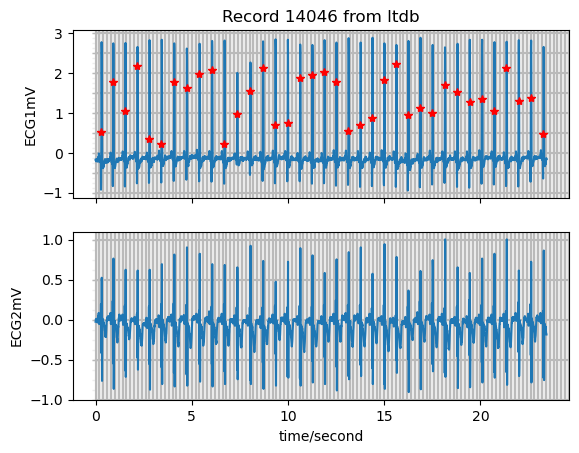

In [135]:
wfdb.plot_wfdb(record=record, annotation=annotation, title='Record 14046 from ltdb', ecg_grids='all')

In [138]:
heartbeats = sliced.slice_heartbeats(num_heartbeats=3)
print(len(heartbeats))

32


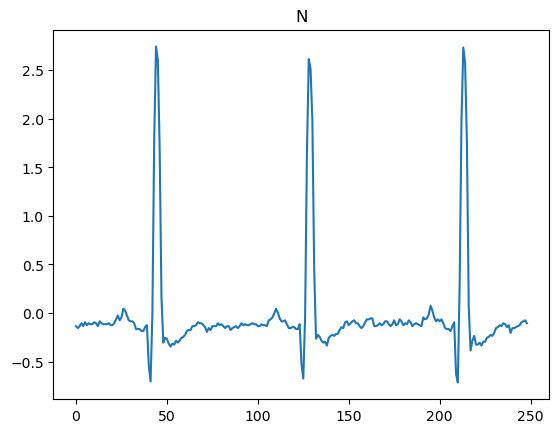

In [149]:
import matplotlib.pyplot as plt

plt.plot(heartbeats[5])
plt.title(annotation.symbol[5])
plt.show()


In [140]:
print(annotation.sample)

[  38  117  197  278  357  438  522  606  691  774  856  941 1029 1113
 1195 1277 1360 1441 1522 1601 1681 1761 1840 1920 2000 2079 2159 2240
 2323 2406 2487 2569 2651 2733 2813 2895 2978]


In [141]:
print(sliced.peak_indices)

[  36  114  194  275  355  436  519  603  688  771  854  938 1026 1110
 1193 1275 1357 1438 1519 1598 1679 1759 1838 1917 1997 2076 2156 2238
 2320 2403 2484 2566 2648 2730 2810 2892 2980]


In [142]:
print(annotation.sample - sliced.peak_indices)

[ 2  3  3  3  2  2  3  3  3  3  2  3  3  3  2  2  3  3  3  3  2  2  2  3
  3  3  3  2  3  3  3  3  3  3  3  3 -2]
